In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Pima 印第安人糖尿病数据集。

In [3]:
# 加载数据
data = pd.read_csv('./datasets/pima-indians-diabetes/diabetes.csv')

In [4]:
data.shape

(768, 9)

In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


+ 0 表示阴性：健康；
+ 1 表示阳性：患病。通常，类标为“1”都是我们关注的类别。

In [6]:
# 看一看数据分布
data.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

In [7]:
X = data.iloc[:, 0:8]
y = data.iloc[:, 8]

In [8]:
X.shape

(768, 8)

In [9]:
y.shape

(768,)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666)

## 模型训练

这里选取 $3$ 个模型。

In [11]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

n_neighbors = 2

models = []
# 1、普通的 k 近邻算法
models.append(("KNN", KNeighborsClassifier(n_neighbors=n_neighbors)))
# 2、带权重的 k 近邻算法
models.append(("KNN with weights",
               KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance")))
# 3、指定半径的 k 近邻算法
models.append(("Radius Neighbors",
               RadiusNeighborsClassifier(n_neighbors=n_neighbors, radius=500.0)))

In [12]:
results = []
for name, model in models:
    model.fit(X_train, y_train)
    results.append((name, model.score(X_test, y_test)))

In [13]:
for i in range(len(results)):
    print("name: {}; score: {}".format(results[i][0], results[i][1]))

name: KNN; score: 0.7207792207792207
name: KNN with weights; score: 0.6623376623376623
name: Radius Neighbors; score: 0.7012987012987013


## 交叉验证

交叉验证可以排除随机选择测试数据集对结果的影响。

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

results = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model, X, y, cv=kfold)
    results.append((name, cv_result))
for i in range(len(results)):
    print("name: {}; cross val score: {}".format(results[i][0],
                                                 results[i][1].mean()))

name: KNN; cross val score: 0.7147641831852358
name: KNN with weights; cross val score: 0.6770505809979495
name: Radius Neighbors; cross val score: 0.6497265892002735


最终使用普通的 k 近邻算法。

In [15]:
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, y_train)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)
print("train score: {}; test score: {}".format(train_score, test_score))

train score: 0.8387622149837134; test score: 0.7207792207792207


过拟合了，说明超参数 `n_neighbors` 的值太小。

In [16]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(plt,
                        estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r")
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g")
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o--',
        color="r",
        label="Training score")
    plt.plot(
        train_sizes,
        test_scores_mean,
        'o-',
        color="g",
        label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [17]:
# 训练数据集的比例
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

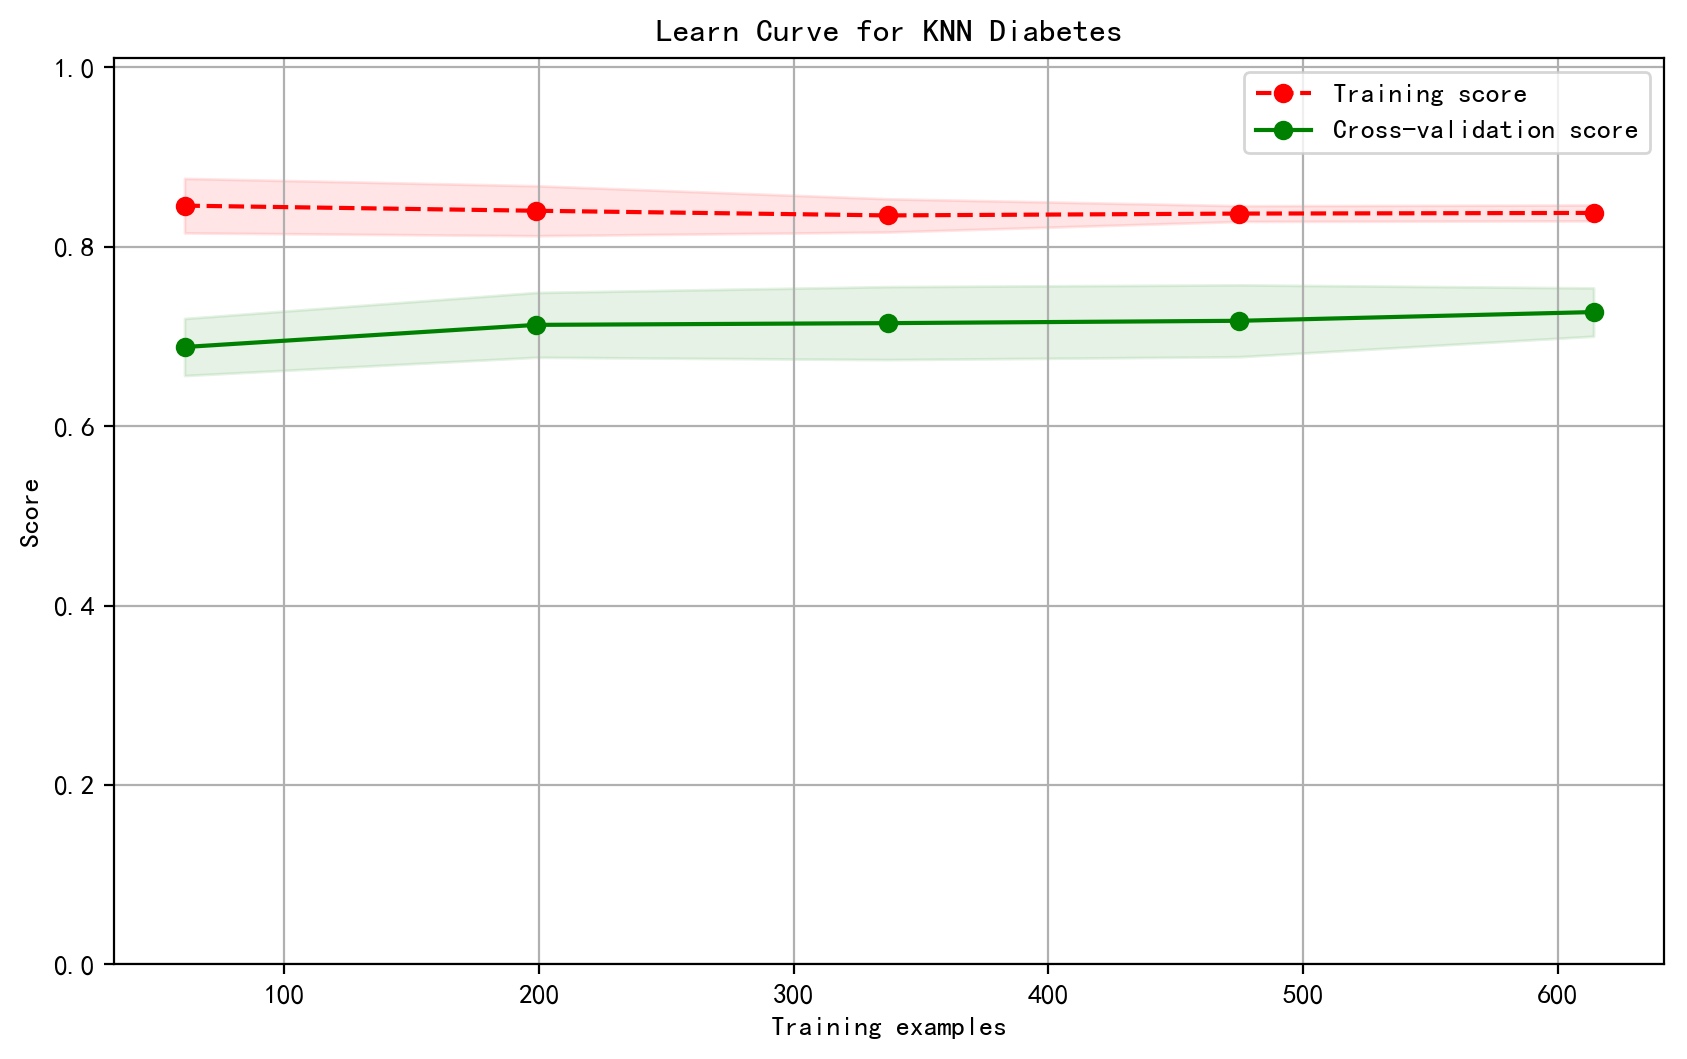

In [18]:
from sklearn.model_selection import ShuffleSplit

knn = KNeighborsClassifier(n_neighbors=2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(10, 6), dpi=100)
plot_learning_curve(
    plt, knn, "Learn Curve for KNN Diabetes", X, y, ylim=(0.0, 1.01), cv=cv)
plt.show()

## 特征选择

只选择 $2$ 个和输出值相关性最大的特征，并且只用它们进行预测和绘图。

参考资料：https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [19]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=2)
X_new = selector.fit_transform(X, y)
X_new[0:5]

array([[148. ,  33.6],
       [ 85. ,  26.6],
       [183. ,  23.3],
       [ 89. ,  28.1],
       [137. ,  43.1]])

In [20]:
np.set_printoptions(threshold = 1e6)

In [21]:
selector.inverse_transform(X_new)

array([[  0. , 148. ,   0. ,   0. ,   0. ,  33.6,   0. ,   0. ],
       [  0. ,  85. ,   0. ,   0. ,   0. ,  26.6,   0. ,   0. ],
       [  0. , 183. ,   0. ,   0. ,   0. ,  23.3,   0. ,   0. ],
       [  0. ,  89. ,   0. ,   0. ,   0. ,  28.1,   0. ,   0. ],
       [  0. , 137. ,   0. ,   0. ,   0. ,  43.1,   0. ,   0. ],
       [  0. , 116. ,   0. ,   0. ,   0. ,  25.6,   0. ,   0. ],
       [  0. ,  78. ,   0. ,   0. ,   0. ,  31. ,   0. ,   0. ],
       [  0. , 115. ,   0. ,   0. ,   0. ,  35.3,   0. ,   0. ],
       [  0. , 197. ,   0. ,   0. ,   0. ,  30.5,   0. ,   0. ],
       [  0. , 125. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 110. ,   0. ,   0. ,   0. ,  37.6,   0. ,   0. ],
       [  0. , 168. ,   0. ,   0. ,   0. ,  38. ,   0. ,   0. ],
       [  0. , 139. ,   0. ,   0. ,   0. ,  27.1,   0. ,   0. ],
       [  0. , 189. ,   0. ,   0. ,   0. ,  30.1,   0. ,   0. ],
       [  0. , 166. ,   0. ,   0. ,   0. ,  25.8,   0. ,   0. ],
       [  0. , 100. ,   0

In [22]:
selector.get_support(indices=True)

array([1, 5])

In [23]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


可以看出，被卡方检验选择出来的特征是 Glucose（血糖浓度）和 BMI（身体质量指数）。

In [24]:
results = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model, X_new, y, cv=kfold)
    results.append((name, cv_result))
for i in range(len(results)):
    print("name: {}; cross val score: {}".format(results[i][0],
                                                 results[i][1].mean()))

name: KNN; cross val score: 0.725205058099795
name: KNN with weights; cross val score: 0.6900375939849623
name: Radius Neighbors; cross val score: 0.6510252904989747


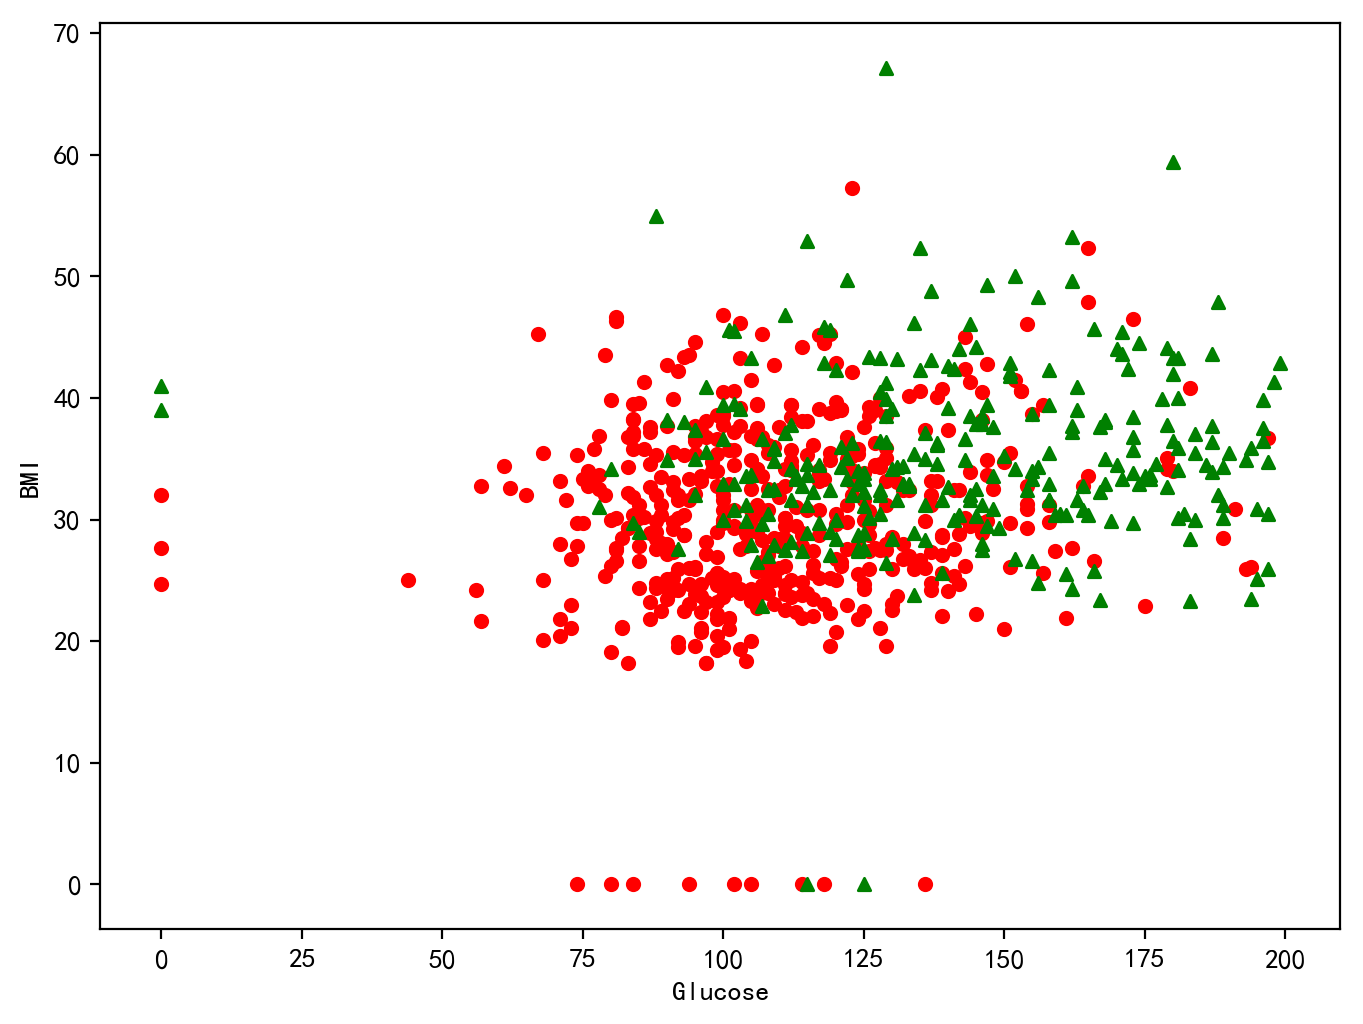

In [25]:
plt.figure(figsize=(8, 6), dpi=100)
plt.ylabel("BMI")
plt.xlabel("Glucose")
plt.scatter(
    X_new[y == 0][:, 0], X_new[y == 0][:, 1], c='r', s=20, marker='o')  # 画出样本
plt.scatter(
    X_new[y == 1][:, 0], X_new[y == 1][:, 1], c='g', s=20, marker='^')  # 画出样本
plt.show()

说明：从上图可以看出，红色样本和绿色样本混在一起了，所以其实 k 近邻算法无法准确预测模型就是这个道理。如果是下面这种情况，k 近邻算法就会有比较好的效果。

![](https://gss0.bdstatic.com/94o3dSag_xI4khGkpoWK1HF6hhy/baike/c0%3Dbaike92%2C5%2C5%2C92%2C30/sign=9199b1866a59252db71a155655f2685e/960a304e251f95ca99a8c12ac3177f3e660952c8.jpg)

## 使用 XGBoost 试试看

In [26]:
from xgboost import XGBClassifier, plot_importance

xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
xgbc.score(X_test, y_test)

0.8181818181818182

In [27]:
model = XGBClassifier(learning_rate=0.1)

eval_set = [(X_test, y_test)]
model.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric="logloss",
    eval_set=eval_set,
    verbose=True)

[0]	validation_0-logloss:0.661619
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.632284
[2]	validation_0-logloss:0.613141
[3]	validation_0-logloss:0.593969
[4]	validation_0-logloss:0.575592
[5]	validation_0-logloss:0.560124
[6]	validation_0-logloss:0.548457
[7]	validation_0-logloss:0.536046
[8]	validation_0-logloss:0.527222
[9]	validation_0-logloss:0.518209
[10]	validation_0-logloss:0.509122
[11]	validation_0-logloss:0.5021
[12]	validation_0-logloss:0.495587
[13]	validation_0-logloss:0.488214
[14]	validation_0-logloss:0.484159
[15]	validation_0-logloss:0.479316
[16]	validation_0-logloss:0.473734
[17]	validation_0-logloss:0.469275
[18]	validation_0-logloss:0.465082
[19]	validation_0-logloss:0.463188
[20]	validation_0-logloss:0.458301
[21]	validation_0-logloss:0.45701
[22]	validation_0-logloss:0.455986
[23]	validation_0-logloss:0.454543
[24]	validation_0-logloss:0.451448
[25]	validation_0-logloss:0.45077
[26]	validation_0-logloss:0.447636
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.8051948051948052

调参以后，准确率反而下降了。